## MCMC

The maximum likelihood estimation (MLE) only gives you a point estimate, what if you want to get a distribution over the parameter space? That's when Markov Chain Monte Carlo (MCMC) comes into play. __EzTao__ provides a simple function, [eztao.ts.carma_mcmc.mcmc](../python/ts.rst#module-eztao.ts.carma_mcmc), to quickly run MCMC using $\mathit{emcee}$ ([the MCMC hammer](https://emcee.readthedocs.io/en/stable/)). However, since it is just a wrapper, it has very limited options. A more advanced/flexible solution is to use __EzTao__ for likelihood computation and hook it with a MCMC sampler that your prefer. 

In the notebook, we will show how to use __EzTao__'s built-in MCMC function as well as use your own MCMC sampler.

####  Built-in MCMC

In [1]:
# general packages
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# eztao, emcee, corner
import eztao
from eztao.carma import CARMA_term
from eztao.ts import gpSimRand
from eztao.ts import mcmc
import emcee
import corner

mpl.rc_file(os.path.join(eztao.__path__[0], "viz/eztao.rc"))

Text(0.5, 1.0, 'Simulated CARMA(3,0) process')

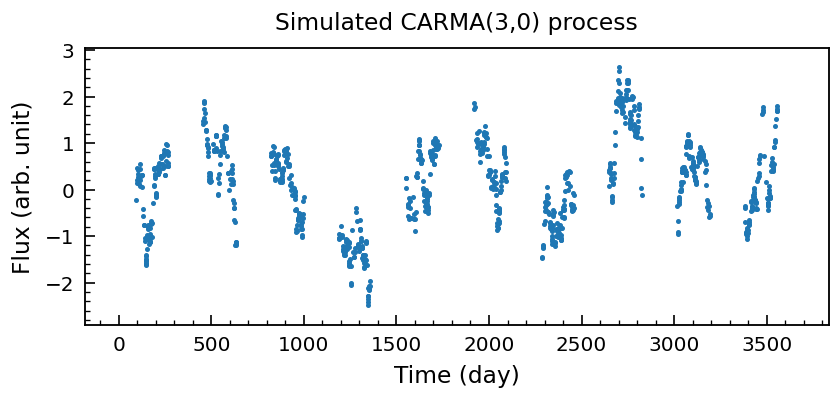

In [2]:
# simulate a CARMA(3,0) process
p = 3
q = 0
carma30_kernel = CARMA_term(np.log([3, 3.189, 0.05]), np.log([0.5]))
t, y, yerr = gpSimRand(carma30_kernel, 100, 365*10, 1000, log_flux=False)

# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=120, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.', markersize=4)
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated CARMA(3,0) process', fontsize=14)

In [3]:
# use built-in function to run MCMC
sampler, carma_flatchain, carma_chain = mcmc(t, y, yerr, 3, 0)

Searching for best-fit CARMA parameters...


/Users/weixiang/Projects/EzTao/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Running burn-in...
Running production...


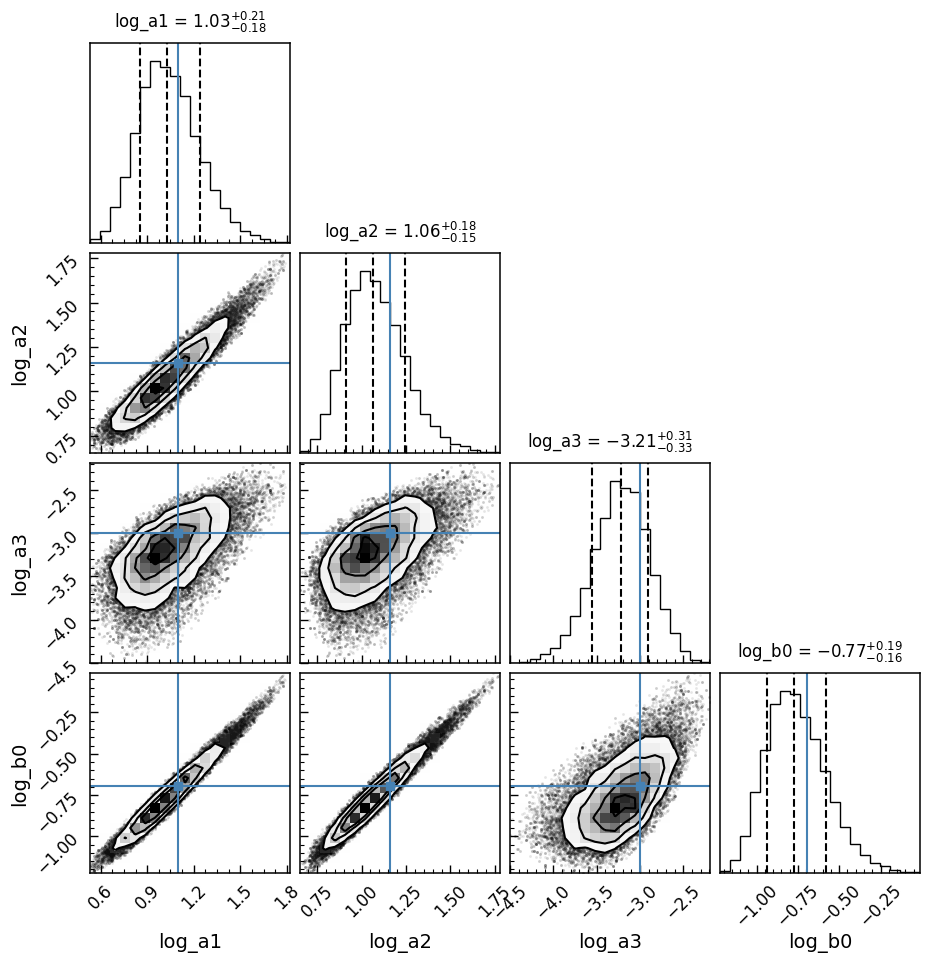

In [4]:
# corner plot
# remove points with low prob for the sake of making good corner plot
prob_threshold = np.percentile(sampler.flatlnprobability, 5)
clean_chain = carma_flatchain[sampler.flatlnprobability > prob_threshold, :]

# make corner plot
labels = [name for name in carma30_kernel.get_parameter_names()]
corner.corner(clean_chain, truths=carma30_kernel.get_parameter_vector(),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});

<div class='alert alert-info'>

Note
    
The ``mcmc`` function returns three variables, the ``emcee`` sampler object, the flatchain in the chain in regular CARMA space. For p > 2, given then reasons mentioned in the [Fiitting](03_Fit.ipynb#Fitting-to-CARMA-models-that-are-higher-than-CARMA(2,1)) notebook (CARMA space vs. polynomial space), the MCMC sampler runs in the polynomial space (which regular user does need to worry about), ``mcmc`` returns the chain and flatchain separately from the ``emcee`` sampler. If the p order is 2 or smaller, the last two variables will just be empty arrays. 
    
    
</div>

#### Use your own MCMC sampler

Here, I will use ``emcee`` for demonstration. To run MCMC with ``emcee``, you will need to define your own probability function. You can either write a simple wrapper around the __EzTao__ likelihood function, ``neg_param_ll`` or ``neg_fcoeff_ll`` (depending on the p order of the CARMA model), to return the `POSITIVE` log likelihood, or write your own probability function.

##### p <= 2

In [5]:
from eztao.ts import neg_param_ll, drw_fit
from eztao.carma import DRW_term
from celerite import GP

Text(0.5, 1.0, 'Simulated DRW process')

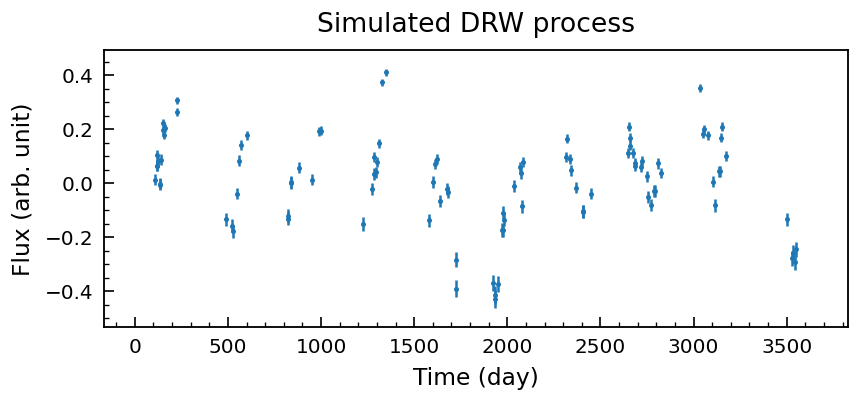

In [6]:
# simulate a DRW process
amp = 0.2
tau = 120
drw_kernel = DRW_term(np.log(amp), np.log(tau))
t2, y2, yerr2 = gpSimRand(drw_kernel, 10, 365*10.0, 100, log_flux=False)

# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=120, figsize=(8,3))
ax.errorbar(t2, y2, yerr2, fmt='.', markersize=4)
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated DRW process')

In [7]:
# obtain best-fit 
best_drw = drw_fit(t2, y2, yerr2)
print(f'Best-fit DRW: {best_drw}')

Best-fit DRW: [  0.18055709 107.90430011]


In [8]:
# define log prob function
def param_ll(*args):
    return -neg_param_ll(*args)

# define celerite GP
drw_gp = GP(DRW_term(*np.log(best_drw)), mean=np.median(y2))
drw_gp.compute(t2, yerr2)

In [9]:
# run MCMC
initial = np.array(np.log(best_drw))
ndim, nwalkers = len(initial), 32
sampler_drw = emcee.EnsembleSampler(nwalkers, ndim, param_ll, args=[y2, drw_gp])

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler_drw.run_mcmc(p0, 500)

print("Running production...")
sampler_drw.reset()
sampler_drw.run_mcmc(p0, 2000);

Running burn-in...
Running production...


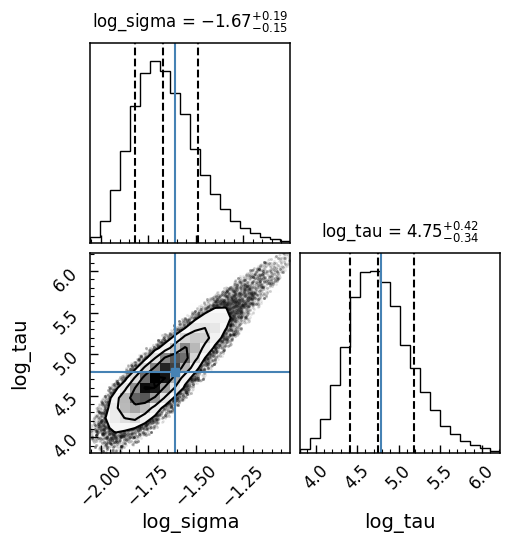

In [10]:
# remove points with low prob for the sake of making good corner plot
prob_threshold_drw = np.percentile(sampler_drw.flatlnprobability, 3)
clean_chain_drw = sampler_drw.flatchain[sampler_drw.flatlnprobability > prob_threshold_drw, :]

# make corner plot
labels = [name for name in drw_gp.kernel.get_parameter_names()]
corner.corner(clean_chain_drw, truths=drw_kernel.get_parameter_vector(),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});

<div class="alert alert-info">

Note

It is always a good practice to start your MCMC walker at a position that is close to the `truth` as MCMC is a sampler not an optimizer. 
</div>

##### p > 2
In this section, we will reuse the simulated CARMA(3,0) process in [Built-in MCMC](#Built-in-MCMC). Since p > 2, we need to start and run MCMC in the factored polynomial space of CARMA, and we will also need to transform the chain from the polynomial space to regular CARMA space once it is done. __EzTao__ provides the functions (see [here](../python/carma.rst#eztao.carma.CARMATerm.CARMA_term.carma2fcoeffs)) to facilitate this process as we will see below. 

In [11]:
from eztao.ts import carma_fit

# obtain best-fit as intial position for MCMC
best_cm30 = carma_fit(t, y, yerr, p, q, n_iter=50)
print(f'Best-fit CARMA(3,0) parameters:{best_cm30}')

/Users/weixiang/Projects/EzTao/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best-fit CARMA(3,0) parameters:[2.68631888 2.79584308 0.03991532 0.44342867]


In [12]:
# get the representation of the best-fit in the polynomial space
best_fcoeffs = CARMA_term.carma2fcoeffs(np.log(best_cm30[:p]), np.log(best_cm30[p:]))
print(f'Best-fit in polynomial space: {best_fcoeffs}')

Best-fit in polynomial space: [2.67184192 2.75716295 0.01447695 0.44342867]


In [13]:
# define log prob function
from eztao.ts import neg_fcoeff_ll

def fcoeff_ll(*args):
    return -neg_fcoeff_ll(*args)

# init GP
cm30_kernel_mcmc = CARMA_term(np.log(best_cm30)[:p], np.log(best_cm30)[p:])
cm30_gp = GP(cm30_kernel_mcmc, mean=np.median(y))
cm30_gp.compute(t, yerr)

In [14]:
# run MCMC
initial_cm30 = np.log(best_fcoeffs)
ndim, nwalkers = len(initial_cm30), 32
sampler_cm30 = emcee.EnsembleSampler(nwalkers, ndim, fcoeff_ll, args=[y, cm30_gp])

print("Running burn-in...")
p0 = initial_cm30 + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler_cm30.run_mcmc(p0, 500)

print("Running production...")
sampler_cm30.reset()
sampler_cm30.run_mcmc(p0, 2000);

Running burn-in...
Running production...


In [15]:
# from the polynomial space to CARMA space
vec_fcoeff2carma = np.vectorize(CARMA_term.fcoeffs2carma, excluded=[1,], signature="(n)->(m),(k)")
ar, ma = vec_fcoeff2carma(sampler_cm30.flatchain, p)
cm30_flatchain = np.log(np.hstack((ar, ma)))

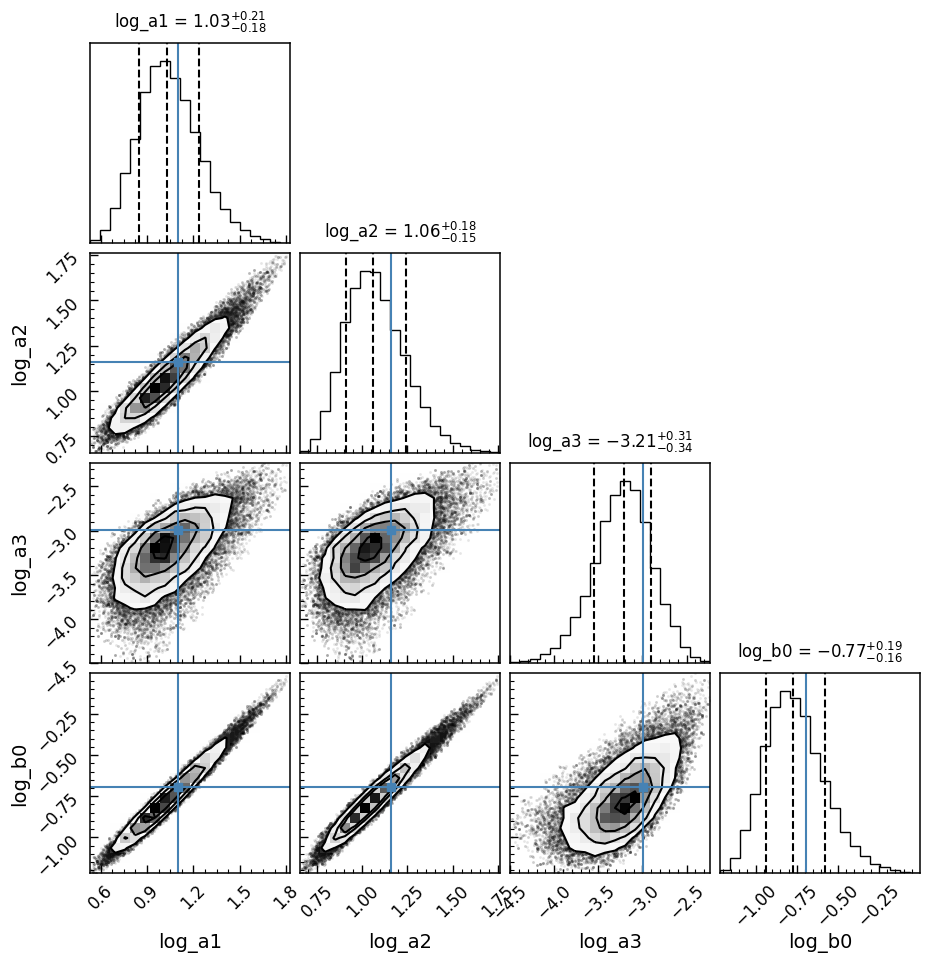

In [16]:
# remove points with low prob for the sake of making good corner plot
prob_threshold_cm30 = np.percentile(sampler_cm30.flatlnprobability, 5)
clean_chain_cm30 = cm30_flatchain[sampler_cm30.flatlnprobability > prob_threshold_cm30, :]

# make corner plot
labels = [name for name in carma30_kernel.get_parameter_names()]
corner.corner(clean_chain_cm30, truths=carma30_kernel.get_parameter_vector(),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});

<div class="alert alert-info">

Note:
    
Extra cautions should be taken when running MCMC with CARMA models of p > 2: 

1. Use ``neg_fcoeff_ll`` as the base log likelihood function.
2. Remember to transform best-fit parameters to the polynomial space when initializing the walker and the chain back to the regular CARMA space when analyzing the chain.

</div>